In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import numpy as np

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16519183.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 495314.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4479279.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1781089.08it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class FeedForwardNN(nn.Module):
  def __init__(self):
    super(FeedForwardNN, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = self.fc5(x)

    return x

model = FeedForwardNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, (images, lables) in enumerate(trainloader):
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, lables)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if (i+1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1, num_epochs, i+1, len(trainloader), running_loss / 100))
      running_loss = 0.0
print('Finished Training')

Epoch [1/10], Step [100/938], Loss 1.1135
Epoch [1/10], Step [200/938], Loss 0.4836
Epoch [1/10], Step [300/938], Loss 0.3884
Epoch [1/10], Step [400/938], Loss 0.3362
Epoch [1/10], Step [500/938], Loss 0.2910
Epoch [1/10], Step [600/938], Loss 0.2616
Epoch [1/10], Step [700/938], Loss 0.2385
Epoch [1/10], Step [800/938], Loss 0.2041
Epoch [1/10], Step [900/938], Loss 0.2027
Epoch [2/10], Step [100/938], Loss 0.1847
Epoch [2/10], Step [200/938], Loss 0.1720
Epoch [2/10], Step [300/938], Loss 0.1676
Epoch [2/10], Step [400/938], Loss 0.1587
Epoch [2/10], Step [500/938], Loss 0.1505
Epoch [2/10], Step [600/938], Loss 0.1550
Epoch [2/10], Step [700/938], Loss 0.1477
Epoch [2/10], Step [800/938], Loss 0.1533
Epoch [2/10], Step [900/938], Loss 0.1487
Epoch [3/10], Step [100/938], Loss 0.1251
Epoch [3/10], Step [200/938], Loss 0.1169
Epoch [3/10], Step [300/938], Loss 0.1275
Epoch [3/10], Step [400/938], Loss 0.1137
Epoch [3/10], Step [500/938], Loss 0.1091
Epoch [3/10], Step [600/938], Loss

In [ ]:
# Testing the model
correct = 0
total = 0
with torch.no_grad():
  for images, lables in testloader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += lables.size(0)
    correct += (predicted == lables).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 96.71 %


# Showing some sample test images and their prediction by the model

Prediction: 9


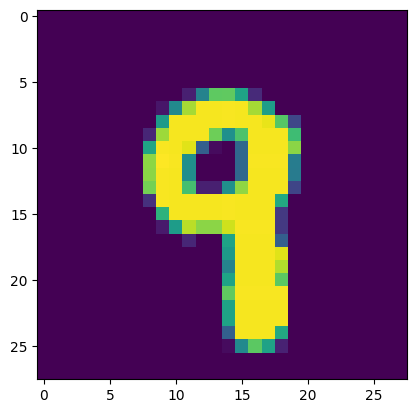

In [ ]:
import matplotlib.pyplot as plt

model.eval()
data, target = testset[214]
data = data.unsqueeze(0)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f'Prediction: {prediction}')
image = data.squeeze(0).squeeze(0).numpy()
plt.imshow(image)
plt.show()

In [ ]:
model.fc1.weight

Parameter containing:
tensor([[ 0.0334,  0.0331,  0.0225,  ...,  0.0275, -0.0046,  0.0025],
        [ 0.0014,  0.0269, -0.0276,  ...,  0.0276,  0.0292,  0.0037],
        [ 0.0051,  0.0355, -0.0115,  ..., -0.0201, -0.0261,  0.0288],
        ...,
        [ 0.0055, -0.0166,  0.0031,  ...,  0.0180, -0.0005,  0.0193],
        [ 0.0073,  0.0188,  0.0073,  ...,  0.0104,  0.0344,  0.0065],
        [-0.0136,  0.0167, -0.0272,  ..., -0.0106, -0.0104, -0.0173]],
       requires_grad=True)

In [ ]:
new_model = FeedForwardNN()
new_model.load_state_dict(model.state_dict())

parameters_to_prune = (
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
    (model.fc4, 'weight'),
    (model.fc5, 'weight')
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.39,  # prune 39% of connections
)

prune.remove(model.fc1, 'weight')
prune.remove(model.fc2, 'weight')
prune.remove(model.fc3, 'weight')
prune.remove(model.fc4, 'weight')
prune.remove(model.fc5, 'weight')

Linear(in_features=64, out_features=10, bias=True)

In [ ]:
# # Testing the model
# correct = 0
# total = 0
# with torch.no_grad():
#   for images, lables in testloader:
#     outputs = new_model(images)
#     _, predicted = torch.max(outputs.data, 1)
#     total += lables.size(0)
#     correct += (predicted == lables).sum().item()

# print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

In [ ]:
torch.backends.quantized.engine = 'qnnpack'

quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

In [ ]:
# Testing the model
correct = 0
total = 0
with torch.no_grad():
  for images, lables in testloader:
    outputs = quantized_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += lables.size(0)
    correct += (predicted == lables).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 96.59 %


In [ ]:
for name, params in quantized_model.named_parameters():
  if 'weight' in name:
    x_abs=abs(params)
    # print(x_abs)
    y=torch.max(x_abs)
    z=torch.min(x_abs)
    # print(z)
    # print(y)
    a = x_abs.detach().numpy().flatten()
    a = np.sort(a)
    # print(a)
    leng=len(a)
    # print(leng)
    # print(a[leng//20])
    with torch.no_grad():
      for i, r in enumerate(params):
        for j, c in enumerate(r):
          if abs(c) < a[int(leng*0.4)]:
             params[i][j] = 0

    print(name, params)
    print('legth %d',leng)

In [ ]:

# updated=model.fc1.weight.detach()
# x_abs=abs(model.fc1.weight)
# print(x_abs)
# y=torch.max(x_abs)
# z=torch.min(x_abs)
# print(z)
# print(y)
# a = x_abs.detach().numpy().flatten()
# a = np.sort(a)
# print(a)
# leng=len(a)
# print(leng)
# print(a[leng//20])
# for i, r in enumerate(updated):
#   for j, c in enumerate(r):
#     if abs(c) < a[leng//20]:
#       updated[i][j] = 0

# print(updated)

In [ ]:
# Testing the model
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f KB" %(os.path.getsize("tmp.pt")/1e3))
    os.remove('tmp.pt')
quantized_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = quantized_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {} %, {} / {}'.format((100 * correct / total), correct, total))
print_model_size(quantized_model)

Accuracy of the network on the 10000 test images: 96.59 %, 9659 / 10000
583.80 KB
